<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal 4
#### Fernando Coda
  
## Primeras nociones de estimación espectral

En esta tarea comnenzaremos con el capítulo 14 de "Holton. DSP Principles and App." y el 8 de "Hayes".

Para una señal
$$\large
x(k)=a_1 \cdot \sin(\Omega_1 \cdot k) + n(k)
$$

siendo 

$$
\Omega_1 = \Omega_0 + f_r \cdot \frac{2 \pi}{N}
$$

$$
\Omega_0 = \frac{\pi}{2}
$$

y las variables aleatorias definidas por

$$
f_r \sim \mathcal{U}(−\frac{1}{2}, \frac{1}{2})
$$

$$
n \sim \mathcal{N}(0, \sigma^2)
$$

Evalúe los siguientes estimadores de $a_1$ y $\Omega_1$

$$
\hat{a}_1 = | X^{i}_w(\Omega) | = | \mathcal{F}\{x(k) \cdot w_i(k)\} |
$$

$$
\hat{\Omega}_1 = \underset{f}{arg\ max} \{\hat{P}\}
$$

Siguiendo las siguientes consignas:

- Considere 200 realizaciones de 1000 muestras para cada experimento.
- Parametrice para SNR's de 3 y 10 dB.

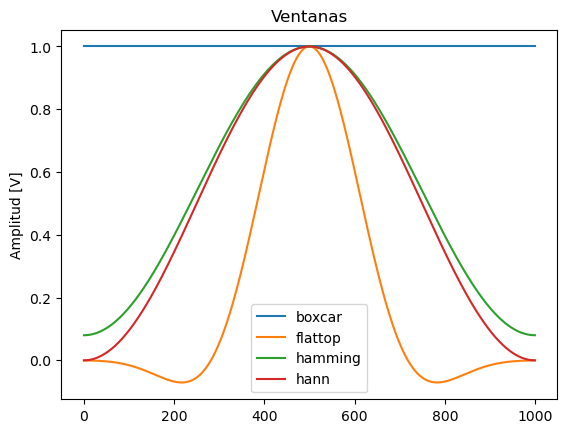

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 21:18:36 2023

@author: feer
"""

import numpy  as np
from pandas import DataFrame
from IPython.display import HTML
from matplotlib import pyplot as plt
from scipy import signal
from astropy.stats import mad_std

def espectro(x_t, fs, N, k):
    df  = fs/N
    f   = np.linspace(0, (N-1)*df, N)
    spec = np.fft.fft( x_t, axis = 0 )
    X_f = 10 * np.log10(np.abs(k/N * spec)**2)
    return X_f, f

def graficar_espectro(axis, X_f, f, fs, *args, **kwargs):   
    bfrec = (f <= fs/2)
    axis.plot(f[bfrec], X_f[bfrec], *args, **kwargs)


# Presentación de ventanas a usar
plt.figure(0).clf()
plt.plot(signal.windows.boxcar(1000),  label='boxcar')
plt.plot(signal.windows.flattop(1000), label='flattop')
plt.plot(signal.windows.hamming(1000), label='hamming')
plt.plot(signal.windows.hann(1000),    label='hann')
plt.legend()
plt.title('Ventanas')
plt.xlabel(''), plt.ylabel('Amplitud [V]')
plt.show()

In [2]:
R = 200  # repeticiones o realizaciones
N = 1000 # nº de muestras

# frec. de sampling normalizada
fs = N
delta_f = fs/N

k = 10 # interpolacion

N_p = k * N
delta_f_p = delta_f / k

# Desplazamiento en frecuencia de cada realización
fr = np.random.uniform(-1/2, 1/2, size=(1,R))

# Frecuencia central normalizada: pi/2 - es equivalente a fs/4
W0 = fs/4
W1 = W0 + fr

SNRs = np.array([ 3, 10 ], dtype=np.float64)
resultados = []

In [3]:
snr_dB = 3

var_noise  = 10 ** (snr_dB / (-10)) # varianza (potencia)
noise = np.random.normal(loc=0.0, scale=np.sqrt(var_noise), size=(N,R))

a1 = np.sqrt(2) # amplitud p/ potencia normalizada

end = N / fs

n = np.linspace(start=0, stop=end, num = N, endpoint = False).reshape((N,1))


x  = a1 * np.sin(2*np.pi * W1 * n) + noise

# Ventaneo
xx_boxcar   = x * signal.windows.boxcar(N).reshape((N,1))
xx_flattop  = x * signal.windows.flattop(N).reshape((N,1))
xx_hamming  = x * signal.windows.hamming(N).reshape((N,1))
xx_hann     = x * signal.windows.hann(N).reshape((N,1))

# Interpolación a 10x
xxx_flattop = np.vstack([xx_flattop, np.zeros([(k-1)*N, R])])
xxx_boxcar  = np.vstack([xx_boxcar,  np.zeros([(k-1)*N, R])])

# Espectros
xx_boxcar_f,  ff  = espectro(xx_boxcar,    fs, N,   1)
xxx_boxcar_f, fff = espectro(xxx_boxcar,   fs, N_p, k)

xx_flattop_f,  ff  = espectro(xx_flattop,  fs, N,   1)
xxx_flattop_f, fff = espectro(xxx_flattop, fs, N_p, k)

xx_hamming_f,  ff  = espectro(xx_hamming,  fs, N,   1)
xx_hann_f,     ff  = espectro(xx_hann,     fs, N,   1)



# ------------- Estimador a1 --------------- #
# a1_est = | F{x(k) . w_i(k)} |
a1_pot_dB = 10.0 * np.log10(np.abs( a1**2/2  )**2)

a1_est_boxcar   = xx_boxcar_f[ff  == W0]
a1_est_flattop  = xx_flattop_f[ff == W0]
a1_est_hamming  = xx_hamming_f[ff == W0]
a1_est_hann     = xx_hann_f[ff == W0]

mediana_a1_boxcar   = np.median(a1_est_boxcar)
mediana_a1_flattop  = np.median(a1_est_flattop)
mediana_a1_hamming  = np.median(a1_est_hamming)
mediana_a1_hann     = np.median(a1_est_hann)

sesgo_a1_boxcar   = mediana_a1_boxcar  - a1_pot_dB
sesgo_a1_flattop  = mediana_a1_flattop - a1_pot_dB
sesgo_a1_hamming  = mediana_a1_hamming - a1_pot_dB
sesgo_a1_hann     = mediana_a1_hann    - a1_pot_dB

std_a1_boxcar   = mad_std(a1_est_boxcar)
std_a1_flattop  = mad_std(a1_est_flattop)
std_a1_hamming  = mad_std(a1_est_hamming)
std_a1_hann     = mad_std(a1_est_hann)


# ------------- Estimador W1 --------------- #
# W1_est =  arg_max_f{ P_est }

W1_est_boxcar  = ff[ np.argmax(xx_boxcar_f  [ff <= fs/2], axis=0) ]
W1_est_flattop = ff[ np.argmax(xx_flattop_f [ff <= fs/2], axis=0) ]
W1_est_hamming = ff[ np.argmax(xx_hamming_f [ff <= fs/2], axis=0) ]
W1_est_hann    = ff[ np.argmax(xx_hann_f    [ff <= fs/2], axis=0) ]


mediana_W1_boxcar  = np.median(W1_est_boxcar )
mediana_W1_flattop = np.median(W1_est_flattop)
mediana_W1_hamming = np.median(W1_est_hamming)
mediana_W1_hann    = np.median(W1_est_hann   )

sesgo_W1_boxcar  = mediana_W1_boxcar  - np.median(W1)
sesgo_W1_flattop = mediana_W1_flattop - np.median(W1)
sesgo_W1_hamming = mediana_W1_hamming - np.median(W1)
sesgo_W1_hann    = mediana_W1_hann    - np.median(W1)

# Uso el desvío estandar porque el MAD me da cero
std_W1_boxcar  = np.std(W1_est_boxcar )
std_W1_flattop = np.std(W1_est_flattop)
std_W1_hamming = np.std(W1_est_hamming)
std_W1_hann    = np.std(W1_est_hann   )


# Guardo los resultados
resultados.append([mediana_W1_boxcar,  sesgo_W1_boxcar,  std_W1_boxcar,  
                   mediana_a1_boxcar,  sesgo_a1_boxcar,  std_a1_boxcar ])
resultados.append([mediana_W1_flattop, sesgo_W1_flattop, std_W1_flattop, 
                   mediana_a1_flattop, sesgo_a1_flattop, std_a1_flattop])
resultados.append([mediana_W1_hamming, sesgo_W1_hamming, std_W1_hamming, 
                   mediana_a1_hamming, sesgo_a1_hamming, std_a1_hamming])
resultados.append([mediana_W1_hann,    sesgo_W1_hann,    std_W1_hann,    
                   mediana_a1_hann,    sesgo_a1_hann,    std_a1_hann])

Graficamos el espectro de la Boxcar y la Flattop

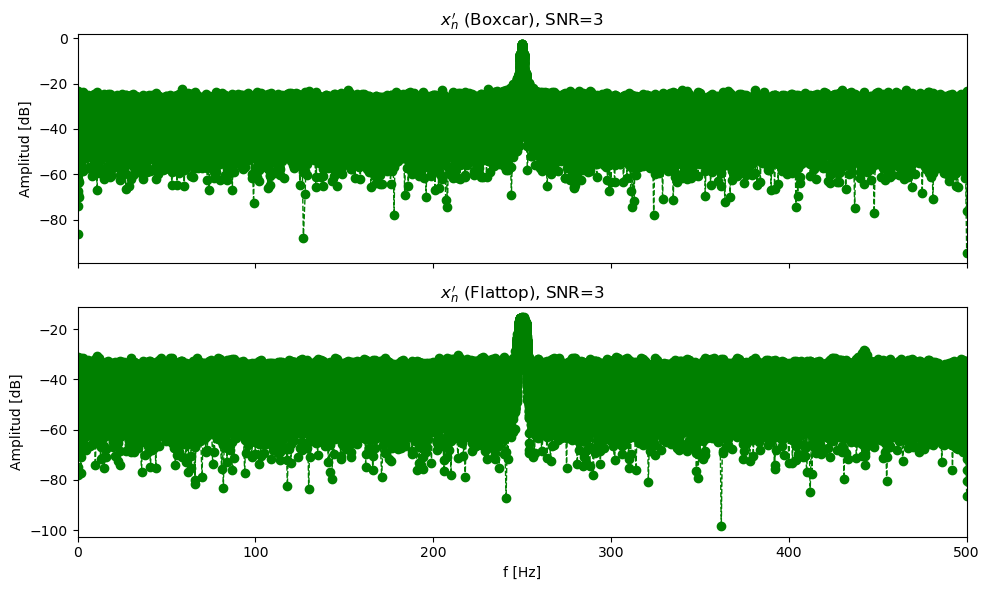

In [4]:
fig, axis = plt.subplots(2, 1, sharex=True, tight_layout=True)
fig.set_figheight(6)
fig.set_figwidth(10)
#------------------------------ boxcar ----------------------------------------#
graficar_espectro(axis[0], xx_boxcar_f,  ff, fs, 'o--g', linewidth=1)
axis[0].set_title('$x_n\'$ (Boxcar), SNR='+str(int(snr_dB)))
axis[0].set_ylabel('Amplitud [dB]')

#----------------------------- flattop ----------------------------------------#
graficar_espectro(axis[1], xx_flattop_f, ff, fs, 'o--g', linewidth=1)
axis[1].set_title('$x_n\'$ (Flattop), SNR='+str(int(snr_dB)))
axis[1].set_xlabel('f [Hz]'), axis[1].set_ylabel('Amplitud [dB]')
plt.xlim([0, fs/2])
plt.show()

Viendo más en detalle lo que sucede en el pico, con una interpolación a 10x para mayor resolución:

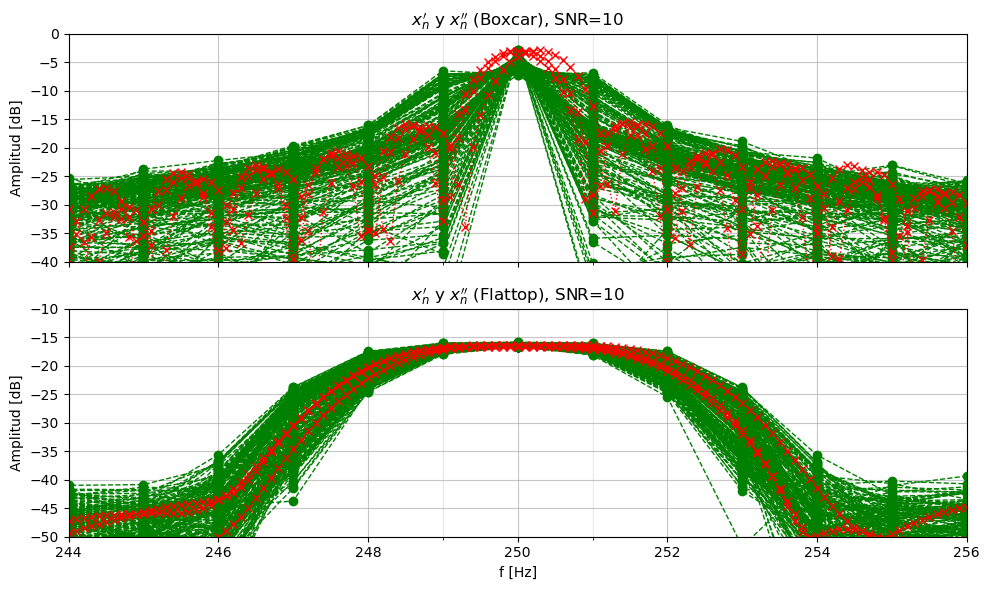

In [12]:
fig, axis = plt.subplots(2, 1, sharex=True, tight_layout=True)
fig.set_figheight(6)
fig.set_figwidth(10)

#------------------------------ boxcar ----------------------------------------#
axis[0].set_xticks(np.linspace(W0-2, W0+2, 5), minor=True)
axis[0].grid(which='major', alpha=0.7)
axis[0].grid(which='minor', alpha=0.3)
graficar_espectro(axis[0],  xx_boxcar_f,         ff, fs, 'o--g', linewidth=1)
graficar_espectro(axis[0], xxx_boxcar_f[:,0:3], fff, fs,  'x:r', linewidth=1)
axis[0].set_title('$x_n\'$ y $x_n\'\'$ (Boxcar), SNR='+str(int(snr_dB)))
axis[0].set_ylabel('Amplitud [dB]')
axis[0].set_ylim([-40,0])

#----------------------------- flattop ----------------------------------------#
axis[1].set_xticks(np.linspace(W0-2, W0+2, 5), minor=True)
axis[1].grid(which='major', alpha=0.7)
axis[1].grid(which='minor', alpha=0.3)

graficar_espectro(axis[1],  xx_flattop_f,         ff,  fs, 'o--g', linewidth=1)
graficar_espectro(axis[1], xxx_flattop_f[:,0:3], fff, fs, 'x:r',  linewidth=1)
axis[1].set_title('$x_n\'$ y $x_n\'\'$ (Flattop), SNR='+str(int(snr_dB)))
axis[1].set_xlabel('f [Hz]'), axis[1].set_ylabel('Amplitud [dB]')
axis[1].set_ylim([-50,-10])
axis[1].set_xlim([W0-6, W0+6])
plt.show()

Ahora graficamos los histogramas de amplitud y frecuencia

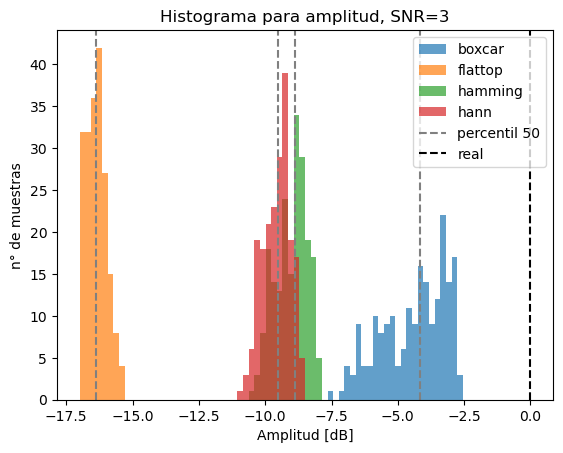

In [6]:
nbins = 80; rang = (-17,0); alpha = 0.7
plt.hist(a1_est_boxcar.transpose(),  bins=nbins, range=rang, alpha=alpha, label='boxcar')
plt.hist(a1_est_flattop.transpose(), bins=nbins, range=rang, alpha=alpha, label='flattop')
plt.hist(a1_est_hamming.transpose(), bins=nbins, range=rang, alpha=alpha, label='hamming')
plt.hist(a1_est_hann.transpose(),    bins=nbins, range=rang, alpha=alpha, label='hann')

plt.axvline(mediana_a1_boxcar,   linestyle='--', color='grey', label='percentil 50')
plt.axvline(mediana_a1_flattop,  linestyle='--', color='grey')
plt.axvline(mediana_a1_hamming,  linestyle='--', color='grey')
plt.axvline(mediana_a1_hann,     linestyle='--', color='grey')
plt.axvline(a1_pot_dB,           linestyle='--', color='black', label='real')

plt.title('Histograma para amplitud, SNR='+str(int(snr_dB)))
plt.xlabel('Amplitud [dB]'), plt.ylabel('n° de muestras')
plt.legend();
plt.show()

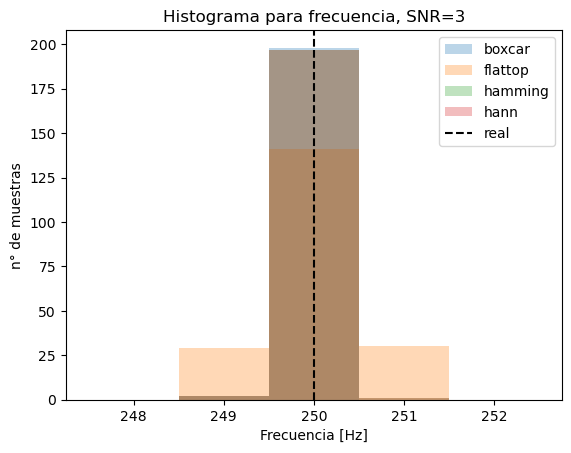

In [7]:
nbins = 5; rang = (247.5,252.5); alpha = 0.3
plt.hist(W1_est_boxcar,  bins=nbins, range=rang, alpha=alpha, label='boxcar')
plt.hist(W1_est_flattop, bins=nbins, range=rang, alpha=alpha, label='flattop')
plt.hist(W1_est_hamming, bins=nbins, range=rang, alpha=alpha, label='hamming')
plt.hist(W1_est_hann,    bins=nbins, range=rang, alpha=alpha, label='hann')
plt.axvline(W0, linestyle='--', color='black', label='real')
plt.title('Histograma para frecuencia, SNR='+str(int(snr_dB)))
plt.xlabel('Frecuencia [Hz]'), plt.ylabel('n° de muestras')
plt.legend();
plt.show()

Repetimos el proceso, ahora con un SNR de 10 dB

In [8]:
snr_dB = 10

var_noise  = 10 ** (snr_dB / (-10)) # varianza (potencia)
noise = np.random.normal(loc=0.0, scale=np.sqrt(var_noise), size=(N,R))

a1 = np.sqrt(2) # amplitud p/ potencia normalizada

end = N / fs

n = np.linspace(start=0, stop=end, num = N, endpoint = False).reshape((N,1))


x  = a1 * np.sin(2*np.pi * W1 * n) + noise

# Ventaneo
xx_boxcar   = x * signal.windows.boxcar(N).reshape((N,1))
xx_flattop  = x * signal.windows.flattop(N).reshape((N,1))
xx_hamming  = x * signal.windows.hamming(N).reshape((N,1))
xx_hann     = x * signal.windows.hann(N).reshape((N,1))

# Interpolación a 10x
xxx_flattop = np.vstack([xx_flattop, np.zeros([(k-1)*N, R])])
xxx_boxcar  = np.vstack([xx_boxcar,  np.zeros([(k-1)*N, R])])

# Espectros
xx_boxcar_f,  ff  = espectro(xx_boxcar,    fs, N,   1)
xxx_boxcar_f, fff = espectro(xxx_boxcar,   fs, N_p, k)

xx_flattop_f,  ff  = espectro(xx_flattop,  fs, N,   1)
xxx_flattop_f, fff = espectro(xxx_flattop, fs, N_p, k)

xx_hamming_f,  ff  = espectro(xx_hamming,  fs, N,   1)
xx_hann_f,     ff  = espectro(xx_hann,     fs, N,   1)



# ------------- Estimador a1 --------------- #
# a1_est = | F{x(k) . w_i(k)} |
a1_pot_dB = 10.0 * np.log10(np.abs( a1**2/2  )**2)

a1_est_boxcar   = xx_boxcar_f[ff  == W0]
a1_est_flattop  = xx_flattop_f[ff == W0]
a1_est_hamming  = xx_hamming_f[ff == W0]
a1_est_hann     = xx_hann_f[ff == W0]

mediana_a1_boxcar   = np.median(a1_est_boxcar)
mediana_a1_flattop  = np.median(a1_est_flattop)
mediana_a1_hamming  = np.median(a1_est_hamming)
mediana_a1_hann     = np.median(a1_est_hann)

sesgo_a1_boxcar   = mediana_a1_boxcar  - a1_pot_dB
sesgo_a1_flattop  = mediana_a1_flattop - a1_pot_dB
sesgo_a1_hamming  = mediana_a1_hamming - a1_pot_dB
sesgo_a1_hann     = mediana_a1_hann    - a1_pot_dB

std_a1_boxcar   = mad_std(a1_est_boxcar)
std_a1_flattop  = mad_std(a1_est_flattop)
std_a1_hamming  = mad_std(a1_est_hamming)
std_a1_hann     = mad_std(a1_est_hann)


# ------------- Estimador W1 --------------- #
# W1_est =  arg_max_f{ P_est }

W1_est_boxcar  = ff[ np.argmax(xx_boxcar_f  [ff <= fs/2], axis=0) ]
W1_est_flattop = ff[ np.argmax(xx_flattop_f [ff <= fs/2], axis=0) ]
W1_est_hamming = ff[ np.argmax(xx_hamming_f [ff <= fs/2], axis=0) ]
W1_est_hann    = ff[ np.argmax(xx_hann_f    [ff <= fs/2], axis=0) ]


mediana_W1_boxcar  = np.median(W1_est_boxcar )
mediana_W1_flattop = np.median(W1_est_flattop)
mediana_W1_hamming = np.median(W1_est_hamming)
mediana_W1_hann    = np.median(W1_est_hann   )

sesgo_W1_boxcar  = mediana_W1_boxcar  - np.median(W1)
sesgo_W1_flattop = mediana_W1_flattop - np.median(W1)
sesgo_W1_hamming = mediana_W1_hamming - np.median(W1)
sesgo_W1_hann    = mediana_W1_hann    - np.median(W1)

# Uso el desvío estandar porque el MAD me da cero
std_W1_boxcar  = np.std(W1_est_boxcar )
std_W1_flattop = np.std(W1_est_flattop)
std_W1_hamming = np.std(W1_est_hamming)
std_W1_hann    = np.std(W1_est_hann   )


# Guardo los resultados
resultados.append([mediana_W1_boxcar,  sesgo_W1_boxcar,  std_W1_boxcar,  
                   mediana_a1_boxcar,  sesgo_a1_boxcar,  std_a1_boxcar ])
resultados.append([mediana_W1_flattop, sesgo_W1_flattop, std_W1_flattop, 
                   mediana_a1_flattop, sesgo_a1_flattop, std_a1_flattop])
resultados.append([mediana_W1_hamming, sesgo_W1_hamming, std_W1_hamming, 
                   mediana_a1_hamming, sesgo_a1_hamming, std_a1_hamming])
resultados.append([mediana_W1_hann,    sesgo_W1_hann,    std_W1_hann,    
                   mediana_a1_hann,    sesgo_a1_hann,    std_a1_hann])

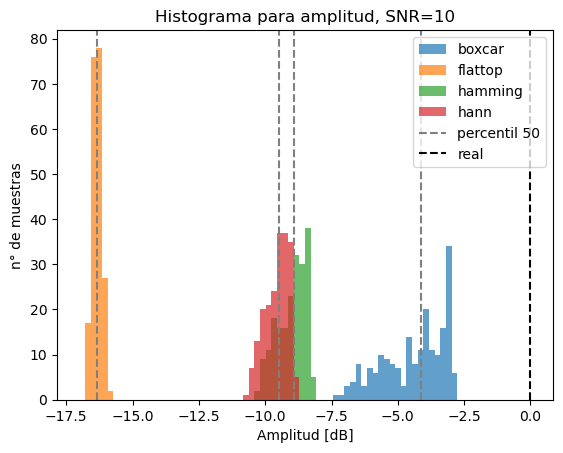

In [9]:
nbins = 80; rang = (-17,0); alpha = 0.7
plt.hist(a1_est_boxcar.transpose(),  bins=nbins, range=rang, alpha=alpha, label='boxcar')
plt.hist(a1_est_flattop.transpose(), bins=nbins, range=rang, alpha=alpha, label='flattop')
plt.hist(a1_est_hamming.transpose(), bins=nbins, range=rang, alpha=alpha, label='hamming')
plt.hist(a1_est_hann.transpose(),    bins=nbins, range=rang, alpha=alpha, label='hann')

plt.axvline(mediana_a1_boxcar,   linestyle='--', color='grey', label='percentil 50')
plt.axvline(mediana_a1_flattop,  linestyle='--', color='grey')
plt.axvline(mediana_a1_hamming,  linestyle='--', color='grey')
plt.axvline(mediana_a1_hann,     linestyle='--', color='grey')
plt.axvline(a1_pot_dB,           linestyle='--', color='black', label='real')

plt.title('Histograma para amplitud, SNR='+str(int(snr_dB)))
plt.xlabel('Amplitud [dB]'), plt.ylabel('n° de muestras')
plt.legend();
plt.show()

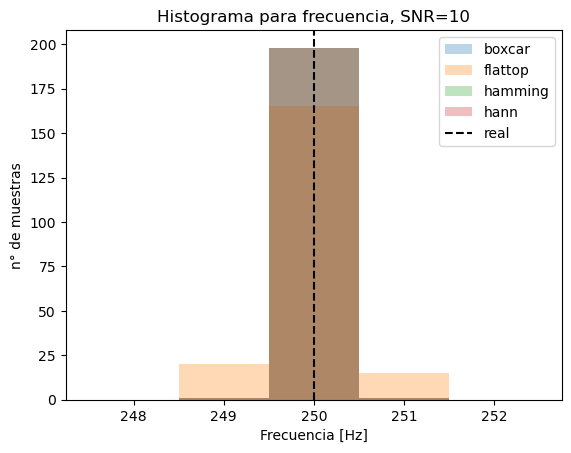

In [10]:
nbins = 5; rang = (247.5,252.5); alpha = 0.3
plt.hist(W1_est_boxcar,  bins=nbins, range=rang, alpha=alpha, label='boxcar')
plt.hist(W1_est_flattop, bins=nbins, range=rang, alpha=alpha, label='flattop')
plt.hist(W1_est_hamming, bins=nbins, range=rang, alpha=alpha, label='hamming')
plt.hist(W1_est_hann,    bins=nbins, range=rang, alpha=alpha, label='hann')
plt.axvline(W0, linestyle='--', color='black', label='real')
plt.title('Histograma para frecuencia, SNR='+str(int(snr_dB)))
plt.xlabel('Frecuencia [Hz]'), plt.ylabel('n° de muestras')
plt.legend();
plt.show()

Por último plasmamos todos los datos en una tabla

In [11]:
df = DataFrame(resultados, columns=['Mediana $\Omega_1$', 'Sesgo $\Omega_1$', 'Desvío std $\Omega_1$', 
                                    'Mediana $X$', 'Sesgo $X$', 'Desvío std $X$'],
               index=[
                         'Boxcar (3 dB)',
                         'Flattop (3 dB)',
                         'Hamming (3 dB)',
                         'Hann (3 dB)',
                         'Boxcar (10 dB)',
                         'Flattop (10 dB)',
                         'Hamming (10 dB)',
                         'Hann (10 dB)',
                     ])

# Dict used to center the table headers
d = dict(selector="th",
    props=[('text-align', 'center')])

# Style
s = df.style.set_properties(**{'width':'10em', 'text-align':'center'})\
      .set_table_styles([d])
        

HTML(s.to_html())


,Mediana $\Omega_1$,Sesgo $\Omega_1$,Desvío std $\Omega_1$,Mediana $X$,Sesgo $X$,Desvío std $X$
Boxcar (3 dB),250.000000,0.029509,0.099499,-4.162962,-4.162962,1.380760
Flattop (3 dB),250.000000,0.029509,0.543116,-16.376365,-16.376365,0.415766
Hamming (3 dB),250.000000,0.029509,0.122372,-8.893770,-8.893770,0.626972
Hann (3 dB),250.000000,0.029509,0.122372,-9.503093,-9.503093,0.518848
Boxcar (10 dB),250.000000,0.029509,0.100000,-4.114813,-4.114813,1.425669
Flattop (10 dB),250.000000,0.029509,0.417582,-16.346452,-16.346452,0.179976
Hamming (10 dB),250.000000,0.029509,0.100000,-8.902825,-8.902825,0.607488
Hann (10 dB),250.000000,0.029509,0.100000,-9.492604,-9.492604,0.483882


Puede apreciarse de la tabla que la ventana Flattop tiene una varianza baja para amplitud, aunque tiene un sesgo muy elevado. Respecto a la frecuencia, tiene la varianza más elevada.  
Por el contrario, la Boxcar no tiene mucho sesgo en amplitud, pero su varianza es demasiado alta. En frecuencia tiene la varianza más baja.  
El caso de la Hamming y la Hann son más equilibradas.  
  
En el caso de $\Omega_1$ no hubo problema para estimar su valor. Sin embargo, la estimación de $a_1$ depende mucho del sesgo del estimador y del tipo de ventaneo utilizado.